In [5]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import os
import json
from scipy.spatial import cKDTree
from interessant import * # Bei Änderungen Kernel neu starten

In [2]:
run = run24
#run = run14
# filename = interessant['OLA gleiche Höhe wie Gleis']

# Bahnsteig: 29; Gleis hohe Intensität: 11; Weiche B: 16; Unterirdischer Bhf: 20; Gleis weit abseits: 23; Betondeckel: 28; Zug run 14 A (in run24 Achszähler): 6; 
# Viele Gleise: 33; Anfang Weiche: 34, OLA gleiche H: 35; Y: 37
key = list(interessant.keys())[0] 
filename = interessant[key]
print(key, filename)

filename = os.path.join(run, filename)
if not os.path.exists(filename):
    raise FileNotFoundError(filename)

Einfach 4473900_5335875.copc.laz


In [19]:
# pipeline = pdal.Pipeline([pdal.Reader(filename)])

pipeline = pdal.Pipeline([pdal.Reader(filename)]) | pdal.Filter.csf() | pdal.Filter.range(limits='Classification[2:2]') 

pipeline.execute()
points = pipeline.arrays[0]
points.dtype # Column names and types

dtype([('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('Synthetic', 'u1'), ('KeyPoint', 'u1'), ('Withheld', 'u1'), ('Overlap', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('ScanChannel', 'u1'), ('Red', '<u2'), ('Green', '<u2'), ('Blue', '<u2')])

In [20]:
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()
offset = xyz.mean(axis=0)
xyz -= offset

xyz.shape

(1222874, 3)

In [28]:
mask = (xyz[:, 0] > -5) & (xyz[:, 0] < 5) & (xyz[:, 1] > -5) & (xyz[:, 1] < 5) 
xyz = xyz[mask]
xyz.shape

(415747, 3)

In [29]:
tree = cKDTree(xyz)

# Query distances to the 3 nearest neighbors (the point itself + 2 nearest)
distances, _ = tree.query(xyz, k=3)

# distances[:, 0] is always 0 (distance to itself), so discard it
nn1 = distances[:, 1]  # Distance to 1st nearest neighbor
nn2 = distances[:, 2]  # Distance to 2nd nearest neighbor

In [31]:
# Basic statistics
print("First Nearest Neighbor Distance:")
print(f"  Mean: {np.mean(nn1):.4f}, Std: {np.std(nn1):.4f}, Min: {np.min(nn1):.4f}, Max: {np.max(nn1):.4f}")
print("Second Nearest Neighbor Distance:")
print(f"  Mean: {np.mean(nn2):.4f}, Std: {np.std(nn2):.4f}, Min: {np.min(nn2):.4f}, Max: {np.max(nn2):.4f}")


First Nearest Neighbor Distance:
  Mean: 0.0068, Std: 0.0041, Min: 0.0002, Max: 0.4347
Second Nearest Neighbor Distance:
  Mean: 0.0094, Std: 0.0057, Min: 0.0022, Max: 0.4377


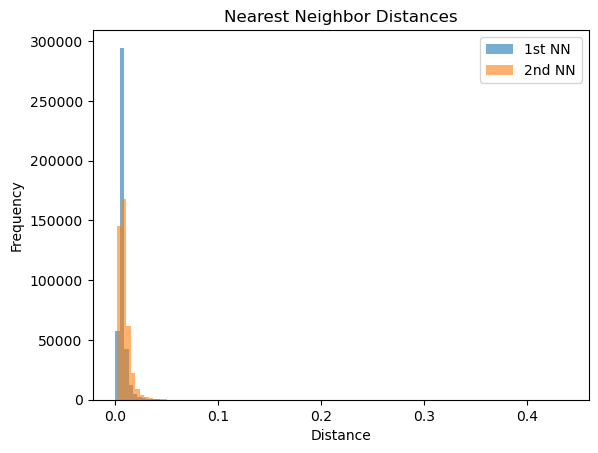

In [32]:
# Optional: Histogram to visualize
plt.hist(nn1, bins=100, alpha=0.6, label='1st NN')
plt.hist(nn2, bins=100, alpha=0.6, label='2nd NN')
plt.legend()
plt.title("Nearest Neighbor Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

Basic statistics after filtering:
  Mean: 0.0081, Median: 0.0065, Std: 0.0048, Min: 0.0002, Max: 0.0995


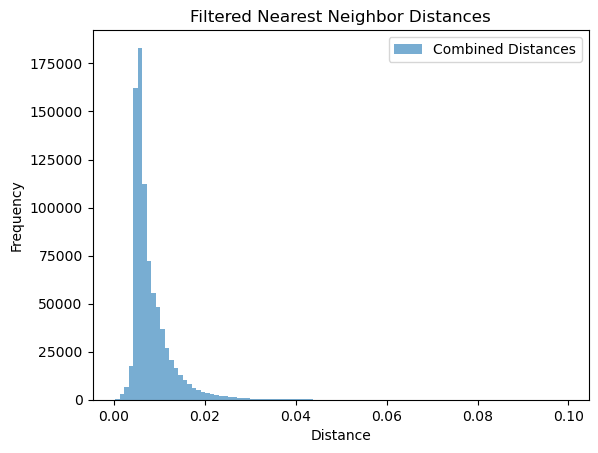

In [33]:
# Set distance threshold
threshold = 0.1  

# Filter: keep only distances below or equal to the threshold
nn1_filtered = nn1[nn1 <= threshold]
nn2_filtered = nn2[nn2 <= threshold]

# Combine into one array
combined_distances = np.concatenate([nn1_filtered, nn2_filtered])

print("Basic statistics after filtering:")
print(f"  Mean: {np.mean(combined_distances):.4f}, Median: {np.median(combined_distances):.4f}, Std: {np.std(combined_distances):.4f}, Min: {np.min(combined_distances):.4f}, Max: {np.max(combined_distances):.4f}")
plt.hist(combined_distances, bins=100, alpha=0.6, label='Combined Distances')
plt.legend()
plt.title("Filtered Nearest Neighbor Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

Basic statistics after filtering:
  Mean: 0.0081, Median: 0.0065, Std: 0.0048, Min: 0.0002, Max: 0.0700


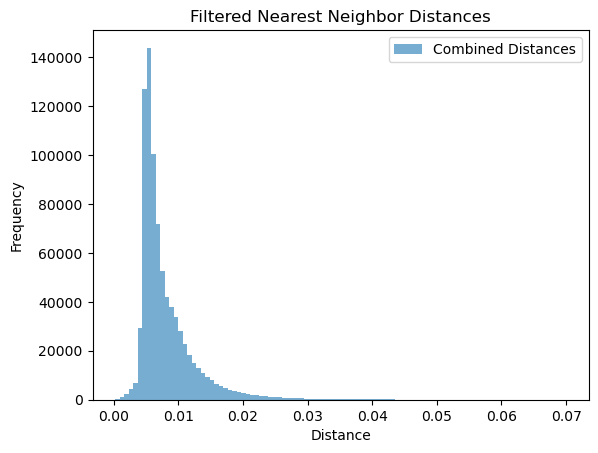

In [35]:
# Set distance threshold
threshold = 0.07

# Filter: keep only distances below or equal to the threshold
nn1_filtered = nn1[nn1 <= threshold]
nn2_filtered = nn2[nn2 <= threshold]

# Combine into one array
combined_distances = np.concatenate([nn1_filtered, nn2_filtered])

print("Basic statistics after filtering:")
print(f"  Mean: {np.mean(combined_distances):.4f}, Median: {np.median(combined_distances):.4f}, Std: {np.std(combined_distances):.4f}, Min: {np.min(combined_distances):.4f}, Max: {np.max(combined_distances):.4f}")
plt.hist(combined_distances, bins=100, alpha=0.6, label='Combined Distances')
plt.legend()
plt.title("Filtered Nearest Neighbor Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

In [34]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)

cmap = plt.get_cmap("viridis")
distance_normalized = nn1 / threshold
distance_normalized = np.clip(distance_normalized, 0, 1)
colors = cmap(distance_normalized)[:, :3]  # Get RGB values from colormap, ignoring alpha channel
pcd.colors = o3d.utility.Vector3dVector(colors)
colors[nn1 > threshold] = [1, 0, 0]  # Red for points outside threshold

axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd, axes])
